In [1]:
import pickle
import torch
import matplotlib.pyplot as plt

### Datasets



We offer two datasets (i.e., [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) and [Tiny ImageNet](https://huggingface.co/datasets/Maysee/tiny-imagenet)) to conduct the experiments. For each task, we offer the following three data files. 

In [2]:
DATA_PATH = 'pickle/tinyimagenet/mobilenetv2/shadow.p'

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with open(DATA_PATH, "rb") as f:
    dataset = pickle.load(f)

print(type(dataset), len(dataset))
print(type(dataset[0]), len(dataset[0]))

print(type(dataset[0][0]), dataset[0][0].shape)
print(type(dataset[0][1]), dataset[0][1])


<class 'list'> 50000
<class 'list'> 2
<class 'torch.Tensor'> torch.Size([3, 64, 64])
<class 'int'> 119


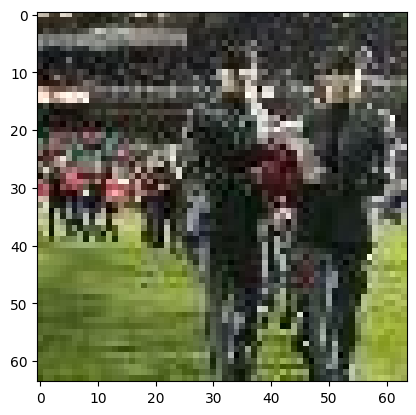

In [3]:
plt.imshow(dataset[0][0].permute(1, 2, 0))

In [4]:
train_dataset = dataset[:int(0.7*(len(dataset)))]
test_dataset = dataset[int(0.7*len(dataset)):]
print(len(train_dataset))
print(len(test_dataset))


35000
15000


In [5]:

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=False, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=2)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=False, num_workers=2)

# for batch_idx, (img, label) in enumerate(dataloader):
#     img = img.to(device)

In [6]:
# DATA_PATH = 'pickle/tinyimagenet/mobilenetv2/eval.p'
# # Change the DATA_PATH to your local pickle file path

# device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# with open(DATA_PATH, "rb") as f:
#     dataset = pickle.load(f)

# print(type(dataset), len(dataset))
# print(type(dataset[0]), len(dataset[0]))

# print(type(dataset[0][0]), dataset[0][0].shape)
# print(type(dataset[0][1]), dataset[0][1])
# print(type(dataset[0][2]), dataset[0][2])


In [7]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=100, shuffle=False, num_workers=2)

# for batch_idx, (img, label, isMemeber) in enumerate(dataloader):
#     img = img.to(device)

### Models

You need to conduct the experiments on two target model architectures (i.e., [ResNet34](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html) and [MobileNetV2](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html)). The pre-trained model weights are provided in the `aamlm/models` folder. You can use the example code below to load the model weights for the ResNet34 target model trained on the CIFAR10 dataset.

In [8]:
import torch
import torchvision.models as models

In [9]:
# MODEL_PATH = 'models/mobilenetv2_tinyimagenet.pth'
# # MODE_PATH = 'trained_models/tinyimagenet/mobilenetv2_496.pth'
# # Change the MODEL_PATH to your local model path

# device=torch.devicea("cuda:0" if torch.cuda.is_available() else "cpu")

# target_model = models.mobilenet_v2(num_classes=200).to(device)
# # Change num_classes to 200 when you use the Tiny ImageNet dataset

# # state_dict = torch.load(MODEL_PATH, map_location=device)
# # target_model.load_state_dict(state_dict['net'])
# # print(state_dict)
# print(target_model)

## SHADOW MODEL

In [10]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

def eval(test_loader, target_model):
    correct = 0
    total = 0
    target_model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
#             images = transform_val(images)
            # calculate outputs by running images through the network
            outputs = target_model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct // total

#     print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return accuracy


In [11]:
from torchvision import models

# shadow_model = models.resnet34(pretrained=True)

shadow_model = models.mobilenet_v2(pretrained=True)

shadow_model.classifier[1] = torch.nn.Linear(shadow_model.classifier[1].in_features, 200)
shadow_model = shadow_model.to(device)


d:\klens\klens_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\klens\klens_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
#load trained shadow model if required
MODEL_PATH = "trained_models/tinyimagenet/mobilenetv2_395_scratch.pth"
state_dict = torch.load(MODEL_PATH, map_location=device)
shadow_model.load_state_dict(state_dict)



<All keys matched successfully>

In [13]:
#Eval Shadow Model if required
eval(test_dataloader, shadow_model)

40

In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(shadow_model.parameters(), lr=0.0005)
last_accuracy = 0


for epoch in range(400):  # loop over the dataset multiple times
    if epoch < 200:
        continue
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        shadow_model.train()

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # inputs = transform_train(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = shadow_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    if epoch%5 == 0:
        print(f'============Evaluating Epoch {epoch}========')
        shadow_model.eval()
        train_accuracy = eval(train_dataloader, shadow_model)
        test_accuracy = eval(test_dataloader, shadow_model)
        print(f"Train Accuracy : {train_accuracy}")
        print(f"Test Accuracy : {test_accuracy}")
        torch.save(shadow_model.state_dict(), f"trained_models/tinyimagenet/mobilenetv2_{epoch}_scratch.pth")
        
#     if accuracy > last_accuracy:
#         torch.save(shadow_model.state_dict(), f"trained_models/tinyimagenet/mobilenetv2_{epoch}.pth")
#         last_accuracy = accuracy

print('Finished Training')

[201,   100] loss: 0.046
[201,   200] loss: 0.038
[201,   300] loss: 0.043
[201,   400] loss: 0.046
[201,   500] loss: 0.045
============Evaluating Epoch 200========
Train Accuracy : 97
Test Accuracy : 40
[202,   100] loss: 0.036
[202,   200] loss: 0.028
[202,   300] loss: 0.041
[202,   400] loss: 0.040
[202,   500] loss: 0.035
[203,   100] loss: 0.045
[203,   200] loss: 0.040
[203,   300] loss: 0.040
[203,   400] loss: 0.041
[203,   500] loss: 0.042
[204,   100] loss: 0.050
[204,   200] loss: 0.039
[204,   300] loss: 0.037
[204,   400] loss: 0.046
[204,   500] loss: 0.039
[205,   100] loss: 0.033
[205,   200] loss: 0.039
[205,   300] loss: 0.031
[205,   400] loss: 0.048
[205,   500] loss: 0.035
[206,   100] loss: 0.033
[206,   200] loss: 0.041
[206,   300] loss: 0.036
[206,   400] loss: 0.032
[206,   500] loss: 0.032
============Evaluating Epoch 205========
Train Accuracy : 98
Test Accuracy : 41
[207,   100] loss: 0.029
[207,   200] loss: 0.028
[207,   300] loss: 0.038
[207,   400] lo

[259,   100] loss: 0.037
[259,   200] loss: 0.026
[259,   300] loss: 0.033
[259,   400] loss: 0.032
[259,   500] loss: 0.036
[260,   100] loss: 0.030
[260,   200] loss: 0.022
[260,   300] loss: 0.025
[260,   400] loss: 0.024
[260,   500] loss: 0.024
[261,   100] loss: 0.019
[261,   200] loss: 0.024
[261,   300] loss: 0.029
[261,   400] loss: 0.028
[261,   500] loss: 0.024
============Evaluating Epoch 260========
Train Accuracy : 97
Test Accuracy : 39
[262,   100] loss: 0.026
[262,   200] loss: 0.028
[262,   300] loss: 0.026
[262,   400] loss: 0.032
[262,   500] loss: 0.025
[263,   100] loss: 0.036
[263,   200] loss: 0.041
[263,   300] loss: 0.046
[263,   400] loss: 0.050
[263,   500] loss: 0.043
[264,   100] loss: 0.030
[264,   200] loss: 0.034
[264,   300] loss: 0.039
[264,   400] loss: 0.028
[264,   500] loss: 0.024
[265,   100] loss: 0.023
[265,   200] loss: 0.022
[265,   300] loss: 0.025
[265,   400] loss: 0.019
[265,   500] loss: 0.032
[266,   100] loss: 0.033
[266,   200] loss: 0

[317,   100] loss: 0.023
[317,   200] loss: 0.023
[317,   300] loss: 0.028
[317,   400] loss: 0.033
[317,   500] loss: 0.026
[318,   100] loss: 0.031
[318,   200] loss: 0.038
[318,   300] loss: 0.041
[318,   400] loss: 0.036
[318,   500] loss: 0.026
[319,   100] loss: 0.027
[319,   200] loss: 0.028
[319,   300] loss: 0.030
[319,   400] loss: 0.023
[319,   500] loss: 0.028
[320,   100] loss: 0.022
[320,   200] loss: 0.025
[320,   300] loss: 0.020
[320,   400] loss: 0.020
[320,   500] loss: 0.026
[321,   100] loss: 0.015
[321,   200] loss: 0.031
[321,   300] loss: 0.027
[321,   400] loss: 0.026
[321,   500] loss: 0.030
============Evaluating Epoch 320========
Train Accuracy : 98
Test Accuracy : 40
[322,   100] loss: 0.033
[322,   200] loss: 0.027
[322,   300] loss: 0.028
[322,   400] loss: 0.024
[322,   500] loss: 0.026
[323,   100] loss: 0.025
[323,   200] loss: 0.024
[323,   300] loss: 0.023
[323,   400] loss: 0.026
[323,   500] loss: 0.031
[324,   100] loss: 0.022
[324,   200] loss: 0

[375,   400] loss: 0.030
[375,   500] loss: 0.036
[376,   100] loss: 0.033
[376,   200] loss: 0.032
[376,   300] loss: 0.041
[376,   400] loss: 0.032
[376,   500] loss: 0.032
============Evaluating Epoch 375========
Train Accuracy : 98
Test Accuracy : 40
[377,   100] loss: 0.023
[377,   200] loss: 0.025
[377,   300] loss: 0.020
[377,   400] loss: 0.023
[377,   500] loss: 0.019
[378,   100] loss: 0.017
[378,   200] loss: 0.012
[378,   300] loss: 0.011
[378,   400] loss: 0.012
[378,   500] loss: 0.013
[379,   100] loss: 0.009
[379,   200] loss: 0.016
[379,   300] loss: 0.012
[379,   400] loss: 0.016
[379,   500] loss: 0.012
[380,   100] loss: 0.018
[380,   200] loss: 0.011
[380,   300] loss: 0.015
[380,   400] loss: 0.023
[380,   500] loss: 0.018
[381,   100] loss: 0.025
[381,   200] loss: 0.027
[381,   300] loss: 0.033
[381,   400] loss: 0.032
[381,   500] loss: 0.033
============Evaluating Epoch 380========
Train Accuracy : 97
Test Accuracy : 39
[382,   100] loss: 0.033
[382,   200] lo

## Create Attack Model Train Data

In [14]:
import numpy as np

shadow_model.eval()
attack_data=[]

for data in train_dataset:
    with torch.no_grad():
        out = shadow_model(data[0].unsqueeze(0).to(device))
        attack_ip = torch.nn.functional.softmax(out[0]).cpu().detach().numpy()
        attack_data.append([attack_ip, 1]) # 1 for member
        
for data in test_dataset:
    with torch.no_grad():
        out = shadow_model(data[0].unsqueeze(0).to(device))
        attack_ip = torch.nn.functional.softmax(out[0]).cpu().detach().numpy()
        attack_data.append([attack_ip, 0]) # 0 for non-member

C:\Users\Piyush\AppData\Local\Temp\ipykernel_19876\1210369659.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attack_ip = torch.nn.functional.softmax(out[0]).cpu().detach().numpy()
C:\Users\Piyush\AppData\Local\Temp\ipykernel_19876\1210369659.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attack_ip = torch.nn.functional.softmax(out[0]).cpu().detach().numpy()


In [15]:
import pickle

with open("attack_dataset.p", "wb") as fp:
    pickle.dump(attack_data, fp)

## Create Attack Model

In [16]:
from torch import nn

class attack_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(200, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.layer_1(x)
        x = nn.functional.relu(x)
        x = self.layer_2(x)
        x = nn.functional.relu(x)
        x = self.layer_3(x)
        return x
    
attack_model = attack_model().to(device)

In [17]:
# attack_model = models.mobilenet_v2(pretrained=True)

# attack_model.classifier[1] = torch.nn.Linear(attack_model.classifier[1].in_features, 2)
# attack_model = attack_model.to(device)
# print(attack_model)


In [18]:
# attack_data[0]

In [19]:
train_dataloader_attack = torch.utils.data.DataLoader(
    attack_data, batch_size=64, shuffle=True, num_workers=2)

In [20]:
weights = torch.tensor([3.34, 1.43]).to(device) ## to deal with class imbalance

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(attack_model.parameters(), lr=0.00005)
last_accuracy = 0


for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader_attack, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        attack_model.train()
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = attack_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    
    if epoch%10 == 0:
#         print(f'============Evaluating Epoch {epoch}========')
#         shadow_model.eval()
#         train_accuracy = eval(train_dataloader, attack_model)
#         test_accuracy = eval(test_dataloader, attack_model)
#         print(f"Train Accuracy : {train_accuracy}")
#         print(f"Test Accuracy : {test_accuracy}")
        torch.save(attack_model.state_dict(), f"trained_models/tinyimagenet/mobilenetv2_{epoch}_attack.pth")

[1,   100] loss: 0.692
[1,   200] loss: 0.688
[1,   300] loss: 0.683
[1,   400] loss: 0.677
[1,   500] loss: 0.670
[1,   600] loss: 0.658
[1,   700] loss: 0.650
[2,   100] loss: 0.628
[2,   200] loss: 0.622
[2,   300] loss: 0.614
[2,   400] loss: 0.607
[2,   500] loss: 0.611
[2,   600] loss: 0.594
[2,   700] loss: 0.588
[3,   100] loss: 0.582
[3,   200] loss: 0.584
[3,   300] loss: 0.576
[3,   400] loss: 0.588
[3,   500] loss: 0.580
[3,   600] loss: 0.582
[3,   700] loss: 0.580
[4,   100] loss: 0.578
[4,   200] loss: 0.567
[4,   300] loss: 0.566
[4,   400] loss: 0.572
[4,   500] loss: 0.573
[4,   600] loss: 0.572
[4,   700] loss: 0.571
[5,   100] loss: 0.575
[5,   200] loss: 0.562
[5,   300] loss: 0.578
[5,   400] loss: 0.561
[5,   500] loss: 0.562
[5,   600] loss: 0.569
[5,   700] loss: 0.556
[6,   100] loss: 0.560
[6,   200] loss: 0.556
[6,   300] loss: 0.567
[6,   400] loss: 0.559
[6,   500] loss: 0.564
[6,   600] loss: 0.565
[6,   700] loss: 0.567
[7,   100] loss: 0.573
[7,   200] 

[50,   200] loss: 0.534
[50,   300] loss: 0.521
[50,   400] loss: 0.518
[50,   500] loss: 0.525
[50,   600] loss: 0.529
[50,   700] loss: 0.515
[51,   100] loss: 0.522
[51,   200] loss: 0.515
[51,   300] loss: 0.533
[51,   400] loss: 0.523
[51,   500] loss: 0.523
[51,   600] loss: 0.522
[51,   700] loss: 0.516
[52,   100] loss: 0.528
[52,   200] loss: 0.516
[52,   300] loss: 0.519
[52,   400] loss: 0.513
[52,   500] loss: 0.528
[52,   600] loss: 0.526
[52,   700] loss: 0.527
[53,   100] loss: 0.516
[53,   200] loss: 0.516
[53,   300] loss: 0.524
[53,   400] loss: 0.522
[53,   500] loss: 0.525
[53,   600] loss: 0.528
[53,   700] loss: 0.521
[54,   100] loss: 0.511
[54,   200] loss: 0.514
[54,   300] loss: 0.535
[54,   400] loss: 0.524
[54,   500] loss: 0.511
[54,   600] loss: 0.520
[54,   700] loss: 0.527
[55,   100] loss: 0.509
[55,   200] loss: 0.518
[55,   300] loss: 0.520
[55,   400] loss: 0.531
[55,   500] loss: 0.537
[55,   600] loss: 0.519
[55,   700] loss: 0.511
[56,   100] loss

[99,   100] loss: 0.500
[99,   200] loss: 0.498
[99,   300] loss: 0.500
[99,   400] loss: 0.500
[99,   500] loss: 0.499
[99,   600] loss: 0.490
[99,   700] loss: 0.497
[100,   100] loss: 0.493
[100,   200] loss: 0.484
[100,   300] loss: 0.507
[100,   400] loss: 0.508
[100,   500] loss: 0.490
[100,   600] loss: 0.493
[100,   700] loss: 0.495


In [21]:
attack_model.eval()
eval(train_dataloader_attack, attack_model)

80

In [27]:
# ##Test Attack model on eval.p
# attack_model = attack_model().to(device)
attack_model_path = "trained_models/tinyimagenet/mobilenetv2_50_attack.pth"
state_dict = torch.load(attack_model_path, map_location=device)
attack_model.load_state_dict(state_dict)

<All keys matched successfully>

In [28]:
##Gokul's code

In [29]:
import torch
import torchvision.models as models

MODEL_PATH = 'models/mobilenetv2_tinyimagenet.pth'
# Change the MODEL_PATH to your local model path
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

target_model = models.mobilenet_v2(num_classes=200).to(device)
# Change num_classes to 200 when you use the Tiny ImageNet dataset

state_dict = torch.load(MODEL_PATH, map_location=device)
target_model.load_state_dict(state_dict['net'])

print(target_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [30]:
DATA_PATH = 'pickle/tinyimagenet/mobilenetv2/eval.p'

with open(DATA_PATH, "rb") as f:
    dataset = pickle.load(f)
    
import numpy as np
## Get logits from target model and give as input to attack model ##

prediction = []
ground_truth  = []

target_model.eval()
for i in range(0,len(dataset)):
    out = target_model(dataset[i][0].unsqueeze(0).to(device))
    target_op = torch.nn.functional.softmax(out[0])
    
    prediction.append(torch.argmax(attack_model(target_op.unsqueeze(0).to(device))).cpu().detach().item())
    ground_truth.append(dataset[i][2])

C:\Users\Piyush\AppData\Local\Temp\ipykernel_19876\2429775316.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  target_op = torch.nn.functional.softmax(out[0])


In [31]:
from sklearn.metrics import accuracy_score

print("Accuracy of attack model on eval dataset:", accuracy_score(ground_truth, prediction))

Accuracy of attack model on eval dataset: 0.875


In [ ]:
DATA_PATH = 'pickle/tinyimagenet/mobilenetv2/test.p'

with open(DATA_PATH, "rb") as f:
    dataset = pickle.load(f)

import numpy as np
## Get logits from target model and give as input to attack model ##

prediction = []
target_model.eval()
for i in range(0,len(dataset)):
    out = target_model(dataset[i][0].unsqueeze(0).to(device))
    target_op = torch.nn.functional.softmax(out[0])
    
    prediction.append(torch.argmax(attack_model(target_op.unsqueeze(0).to(device))).cpu().detach().item())

np.save('results/task3_mobilenetv2_tinyimagenet.npy', prediction)

### Eval Attack model on eval.p

In [ ]:
# def eval_attack(test_loader, shadow_model, attack_model):
#     correct = 0
#     total = 0
#     shadow_model.eval()
#     attack_model.eval()
#     # since we're not training, we don't need to calculate the gradients for our outputs
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels, member = data
#             images = images.to(device)
#             member = member.to(device)
            
#             out = shadow_model(images.to(device))
#             attack_ip = torch.nn.functional.softmax(out).cpu().detach().numpy()
# #             print(attack_ip.shape)
# #             print(attack_ip[0])
#             sorted_attack_ip = np.sort(attack_ip,1)[:,:10]
# #             print(sorted_attack_ip[0])
#             sorted_attack_ip = torch.tensor(sorted_attack_ip.copy()).to(device)
# #             print(sorted_attack_ip.shape)
#             outputs = attack_model(sorted_attack_ip)
#             # the class with the highest energy is what we choose as prediction
#             _, predicted = torch.max(outputs.data, 1)
#             total += member.size(0)
#             correct += (predicted == member).sum().item()
#     accuracy = 100 * correct // total

# #     print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
#     return accuracy


In [ ]:
# DATA_PATH = 'pickle/tinyimagenet/mobilenetv2/eval.p'
# # Change the DATA_PATH to your local pickle file path

# device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# with open(DATA_PATH, "rb") as f:
#     dataset = pickle.load(f)


# print(type(dataset), len(dataset))
# print(type(dataset[0]), len(dataset[0]))

# print(type(dataset[0][0]), dataset[0][0].shape)
# print(type(dataset[0][1]), dataset[0][1])
# print(type(dataset[0][2]), dataset[0][2])


In [ ]:
# eval_dataloader_attack = torch.utils.data.DataLoader(
#     dataset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
# eval_attack(eval_dataloader_attack, shadow_model, attack_model)

# Submission

You need to **submit your final prediction results on the test dataset `test.p` to [hai.huang@cispa.de](mailto:hai.huang@cispa.de) or [yugeng.liu@cispa.de](mailto:yugeng.liu@cispa.de)** to be checked by us. There should be **four** prediction result files in your submission.

In [ ]:
# DATA_PATH = 'test/pickle/cifar10/resnet34/test.p'

# with open(DATA_PATH, "rb") as f:
#     dataset = pickle.load(f)

# import numpy as np

# prediction = [1 for i in range(len(dataset))]

# np.save('./results/task0_resnet34_cifar10.npy', prediction)
# np.save('./results/task1_mobilenetv2_cifar10.npy', prediction)
# np.save('./results/task2_resnet34_tinyimagenet.npy', prediction)
# np.save('./results/task3_mobilenetv2_tinyimagenet.npy', prediction)

### File Name

| File Name | Task ID | Dataset | Model |
| :- | :-: | :-: | :-: |
| `task0_resnet34_cifar10.npy` | 0 | CIFAR10 | ResNet34 |
| `task1_mobilenetv2_cifar10.npy` | 1 | CIFAR10 | MobileNetV2 |
| `task2_resnet34_tinyimagenet.npy` | 2 | Tiny ImageNet | ResNet34 |
| `task3_mobilenetv2_tinyimagenet.npy` | 3 | Tiny ImageNet | MobileNetV2 |

### Run the test code

In [ ]:
!python run.py --path ./results
!python run.py --path ./c01hahu
!python run.py --path ./